# Introduction

This notebook demostrates the prediction pipeline for the trained classifiers. With the 3 pretrained classifiers, you can easily classify a new structure that is not included in the original training set.

**Note**: For easier readability, you can change the fontsize of this notebook by navigating to `Settings` -> `JupyterLab Theme` and increasing or decreasing the fontsize from the dropdown menu.

# Import packages and functions

In [1]:
import sys
# force the notebook to look for files in the upper level directory
sys.path.insert(1, '../')

In [2]:
import pandas as pd
import xgboost as xgb
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import IFrame
from sklearn.impute import KNNImputer
from model.model_building import load_data
from data.data_cleaning import abbreviate_features
from data.compound_featurizer import read_new_struct, composition_featurizer, structure_featurizer, handbuilt_featurizer

# Set up constants
The `REDUCED_PATH` contains the data with the reduced feature set, used to train the classifiers. The `FULL_PATH` contains the data with the full feature set. Essentially, in terms of the number of predictors, the reduced feature dataset is a subset of the full feature dataset, with features selected according to SHAP feature importance and domain knowledge.

The `NEW_STRUCT_PATH` contains the demo CIF structure file and you can _**test your own structure**_ by uploading the CIF file to the "user_defined_structures" folder and changing the `NEW_STRUCT_PATH`. You can save time by pressing <kbd>⇥ Tab</kbd> for auto-completion after typing the first few words.

**Note**: If you choose to upload your own cif structure file, it is preferable that the structure already has an oxidation state assigned to each site. If not, the featurizer will try to guess the oxidation states using the [oxi_state_guesses()](https://pymatgen.org/pymatgen.core.composition.html?highlight=oxi_state_guesses#pymatgen.core.composition.Composition.oxi_state_guesses) function from Pymatgen. There is no guarantee that the guessed oxidation states will be correct and the script will also ask for user input if it is unable to guess the oxidation states. In addition, the uploaded structure has to have at least **2 different elements** (i.e. at least a binary compound). A single element structure such as Si will lead to an error in the script.

There are 3 demo structures: CuNiO$_2$, Ca2CoN$_2$ and Ga(MoSe$_2$)$_4$ for you to try out and they are not present in the training database. 

In [3]:
REDUCED_PATH = "../data/processed/IMT_Classification_Dataset_Reduced_Feature_Set_v9.xlsx"
FULL_PATH = "../data/processed/IMT_Classification_Dataset_Full_Feature_Set_v9.xlsx"
NEW_STRUCT_PATH = "./user_defined_structures/CuNiO2_mp-1178372_primitive.cif"

# Define some helper functions

In [4]:
def assign_oxi_state(elem_symbol):
    """Allow the user to assign oxidation state to each element."""
    oxi_state = input("{}:".format(elem_symbol))
    return float(oxi_state)


def check_oxi_state(structure):
    """Check if the guessed oxidation states are all zero. If so, trigger user input."""
    if not structure.composition.oxi_state_guesses():
        # get all the elements in the input structure
        elem_lst = [element.symbol for element in structure.composition.element_composition.elements]
        # get the reduced formula
        reduced_formula = structure.composition.reduced_formula
        print("Unable to guess oxidation states for {}. Please manually assign oxidation states by element".format(reduced_formula))
        # get a dictionary to overwrite the default guessed oxidation states
        elem_oxi_states = {elem_symbol: [assign_oxi_state(elem_symbol)] for elem_symbol in elem_lst}
        return elem_oxi_states
    return None


def featurizer_wrapper(df_input):
    """A wrapper function around the composition, structure and handbuilt featurizers."""
    # get the structure from the initialized dataframe
    new_struct = df_input.at[0, "structure"]
    # check if the guessed oxidation states are all zeros and allow user-overwrite if true
    oxi_states_by_element = check_oxi_state(new_struct)
    # featurize the given structure using 3 predefined featurizers
    df_output = composition_featurizer(df_input, oxi_states_override=oxi_states_by_element)
    df_output = structure_featurizer(df_output, oxi_states_override=oxi_states_by_element)
    df_output = handbuilt_featurizer(df_output)
    return df_output


def process_new_struct_df(df_new, df_full_set):
    """Process the newly featurized structure and impute any missing values with KNNImputer"""
    new_struct_df_with_name = abbreviate_features(df_new)
    # check if the dataframe contains missing values: if not, then return immediately
    if new_struct_df_with_name.isna().sum(axis=1)[0] == 0:
        return new_struct_df_with_name.drop(columns="Compound"), new_struct_df_with_name
    # select the same features as the full feature set
    new_struct_df = new_struct_df_with_name.filter(items=df_full_set.columns).drop(columns="Compound")
    # combine the full feature set with the new structure's features
    df_with_new_struct = pd.concat([df_full_set.drop(columns=["Compound", "Label", "struct_file_path"]), 
                                    new_struct_df], ignore_index=True)
    
    # impute the missing values with the values from the 5 nearest neighbors 
    # weighted by their distances to the new structures' non-missing values
    knn_imputer = KNNImputer(n_neighbors=5, weights="distance")
    # get the imputed dataframe for the new structure
    new_struct_df_imputed = knn_imputer.fit_transform(df_with_new_struct)[-1]
    # add back the column names
    new_struct_df = pd.DataFrame([new_struct_df_imputed], columns=new_struct_df.columns)
    # get the new structure name and create a copy of new_struct_df with the compound name
    new_struct_name = new_struct_df_with_name.at[0, "Compound"]
    new_struct_df_with_name = new_struct_df.copy()
    new_struct_df_with_name["Compound"] = new_struct_name
    return new_struct_df, new_struct_df_with_name

# Read in the reduced dataset

This is a quick overview of the training dataset. It will be used later on to select the relevant features from the raw output of the featurizer.

In [5]:
df = pd.read_excel(REDUCED_PATH)
df

,Compound,Label,struct_file_path,gii,est_hubbard_u,est_charge_trans,ewald_energy_per_atom,maximum_MendeleevNumber,range_MendeleevNumber,avg_dev_CovalentRadius,avg_mm_dists,avg_mx_dists,avg_xx_dists
0,BaMoO3,0,../data/Structures/Metals/BaMoO3_CollCode_2915...,0.321007,10.523409,11.946426,-35.287498,87,78,56.880000,4.040770,2.020385,2.857256
1,BaNiS2,0,../data/Structures/Metals/BaNiS2_CollCode_2469...,0.195702,12.893512,21.595766,-18.401393,88,79,38.875000,3.491120,2.331183,3.654519
2,BaOsO3,0,../data/Structures/Metals/BaOsO3_SD_0375565.cif,0.817185,8.412244,3.591515,-32.606822,87,78,54.480000,2.577001,2.105553,2.978994
3,Bi2Ru2O7,0,../data/Structures/Metals/Bi2Ru2O7_CollCode_73...,0.277386,10.043255,11.876142,-39.922005,87,31,37.487603,3.639266,1.938742,3.077187
4,Ca3Ru2O7,0,../data/Structures/Metals/Ca3Ru2O7_CollCode_15...,0.117212,10.277936,8.827434,-33.810870,87,80,47.638889,3.868727,1.992857,2.933553
...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,V6O13,2,../data/Structures/MIT_materials/HighT/V6O13_H...,0.198242,58.592940,-12.467020,-51.589654,87,41,37.595568,3.387826,1.938791,2.767633
224,V8O15,2,../data/Structures/MIT_materials/HighT/V8O15_H...,0.296188,13.875184,11.940681,-44.765762,87,41,39.470699,3.269840,1.952518,2.819850
225,VO2,2,../data/Structures/MIT_materials/HighT/VO2_HT_...,0.128538,14.484546,9.779242,-47.781257,87,41,38.666667,3.522330,1.927294,2.675472
226,YNiO3,2,../data/Structures/MIT_materials/HighT/YNiO3_6...,0.231001,15.898371,10.393278,-34.202393,87,75,43.680000,3.755161,1.963601,2.827539


As we can see here, the processed dataset used for training the classifier has 228 unique compounds and 13 columns. Excluding `Compound`, `Label` and `struct_file_path`, there are 10 features used for prediction (i.e. 10 predictors).

# Make a prediction on a never-before-seen structure

## 1. Load the three trained models

In [6]:
# load the metal vs. non_metal classifier
metal_model = xgb.XGBClassifier()
metal_model.load_model("../model/saved_models/new_models/metal_reduced.model")

# load the insulator vs. non_insulator classifier
insulator_model = xgb.XGBClassifier()
insulator_model.load_model("../model/saved_models/new_models/insulator_reduced.model")

# load the mit vs. non_mit classifier
mit_model = xgb.XGBClassifier()
mit_model.load_model("../model/saved_models/new_models/mit_reduced.model")

## 2. Read in and featurize the new structure

In [7]:
new_struct_df = read_new_struct(NEW_STRUCT_PATH)
new_struct_df = featurizer_wrapper(new_struct_df)

/Users/jasonrpw/PycharmProjects/mit_model_code/venv/lib/python3.7/site-packages/tqdm/std.py:670: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Here is the raw output from the featurizer.

In [8]:
new_struct_df

,Compound,structure,composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,...,max_xx_dists,min_xx_dists,avg_xx_dists,v_m,v_x,iv,iv_p1,est_hubbard_u,est_charge_trans,volume_per_site
0,CuNiO2,"[[0. 0. 0.] Cu, [0. 0. 2.84837...","(Cu, Ni, O)",8.0,29.0,21.0,18.25,10.25,8.0,61.0,...,2.864732,2.77446,2.817046,-24.969425,23.63686,18.168838,35.187,11.991636,15.842407,9.840079


## 3. Only select predictors that are in the reduced feature set

We need to load in the dataset with the full feature set to help impute the missing values in the newly featurized structure, should there be any. The imputing process utilizes the [KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) from scikit-learn.

In [9]:
df_full = pd.read_excel(FULL_PATH)
df_full

,Compound,Label,struct_file_path,maximum_MendeleevNumber,range_MendeleevNumber,avg_dev_MendeleevNumber,range_AtomicWeight,mean_AtomicWeight,avg_dev_AtomicWeight,mode_AtomicWeight,...,max_xx_dists,min_xx_dists,avg_xx_dists,v_m,v_x,iv,iv_p1,est_hubbard_u,est_charge_trans,volume_per_site
0,BaMoO3,0,../data/Structures/Metals/BaMoO3_CollCode_2915...,87,78,27.600000,121.32760,56.257040,48.309168,15.9994,...,2.857256,2.857256,2.857256,-44.108215,23.006209,40.330000,54.417000,10.523409,11.946426,13.195395
1,BaNiS2,0,../data/Structures/Metals/BaNiS2_CollCode_2469...,88,79,26.500000,105.26200,65.037600,36.144700,32.0650,...,3.783737,3.137645,3.654519,-21.082598,20.132993,18.168838,35.187000,12.893512,21.595766,21.929081
2,BaOsO3,0,../data/Structures/Metals/BaOsO3_SD_0375565.cif,87,78,25.920000,174.23060,75.111040,70.933968,15.9994,...,3.100000,2.893540,2.978994,-36.659700,22.481523,41.000000,55.000000,8.412244,3.591515,16.289915
3,Bi2Ru2O7,0,../data/Structures/Metals/Bi2Ru2O7_CollCode_73...,87,31,9.157025,192.98100,66.554236,64.342519,15.9994,...,3.691300,2.717536,3.077187,-47.298875,24.715398,45.000000,59.000000,10.043255,11.876142,12.393497
4,Ca3Ru2O7,0,../data/Structures/Metals/Ca3Ru2O7_CollCode_15...,87,80,29.361111,85.07060,36.197483,23.564431,15.9994,...,3.488882,2.740999,2.933553,-43.378203,25.385677,45.000000,59.000000,10.277936,8.827434,12.120246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,V6O13,2,../data/Structures/MIT_materials/HighT/V6O13_H...,87,41,17.717452,34.94210,27.033747,15.099633,15.9994,...,3.269140,2.461773,2.767633,-32.743339,35.209237,65.281650,128.125000,58.592940,-12.467020,11.494831
224,V8O15,2,../data/Structures/MIT_materials/HighT/V8O15_H...,87,41,18.601134,34.94210,28.153174,15.852749,15.9994,...,3.474319,2.529565,2.819850,-38.212724,31.173210,42.359525,60.638487,13.875184,11.940681,9.935308
225,VO2,2,../data/Structures/MIT_materials/HighT/VO2_HT_...,87,41,18.222222,34.94210,27.646767,15.529822,15.9994,...,2.725617,2.575183,2.675472,-45.333235,26.337259,46.709000,65.281650,14.484546,9.779242,9.863262
226,YNiO3,2,../data/Structures/MIT_materials/HighT/YNiO3_6...,87,75,24.240000,72.90645,39.119490,27.744108,15.9994,...,3.184308,2.736503,2.827539,-36.802534,23.821848,35.187000,54.920000,15.898371,10.393278,10.686816


In [10]:
new_struct_df, new_struct_df_with_name = process_new_struct_df(new_struct_df, df_full)
new_struct_df = new_struct_df.filter(items=df.columns)
new_struct_df

,gii,est_hubbard_u,est_charge_trans,ewald_energy_per_atom,maximum_MendeleevNumber,range_MendeleevNumber,avg_dev_CovalentRadius,avg_mm_dists,avg_mx_dists,avg_xx_dists
0,0.132573,11.991636,15.842407,-23.755873,87.0,26.0,31.0,2.864732,2.091688,2.817046


Here is a printout of the number of predictors in the newly featurized structure

In [11]:
new_struct_df.shape[1]

10

Compare the number of predictors with the training data loaded into the MIT classifier

In [12]:
train_x, _ = load_data(df, "MIT")
train_x.shape[1]

10

## 4. Print out the prediction label and probability

After selecting the relevant features, we are now ready to make a prediction for the given structure. Below, you will see the outputs from the metal vs. non_metal, insulator vs. non_insulator and mit vs. non_mit classifiers. `1` means the structure is predicted to the positive class and `0` means it is predicted to be the negative class.

**Note**: It is possible for the classifier to classify a structure as multiple classes. (e.g. as both a metal and an MIT). We've provided you with the probability of each prediction and we'll let you be the final judge.

In [13]:
print("Is a metal: {}, and the probability of being a metal is :{:0.4f}\n".format(metal_model.predict(new_struct_df)[0], metal_model.predict_proba(new_struct_df)[0][1]))
print("Is an insulator: {}, and the probability of being an insulator is :{:0.4f}\n".format(insulator_model.predict(new_struct_df)[0], 
                                                                                    insulator_model.predict_proba(new_struct_df)[0][1]))
print("Is an mit: {}, and the probability of being an mit is :{:0.4f}".format(mit_model.predict(new_struct_df)[0], mit_model.predict_proba(new_struct_df)[0][1]))

Is a metal: 0, and the probability of being a metal is :0.1843

Is an insulator: 1, and the probability of being an insulator is :0.9990

Is an mit: 0, and the probability of being an mit is :0.0001


## 5. Plot the data using the Range Mendeleev Number & the Average Deviation of the Covalent Radius

These two features are identified with high feature importance for the MIT vs. non-MIT classifier and have been shown to separate MITs from the non-MITs quite well.

We can plot all the datapoints (training set + the new structure) on a 2D scatter plot of `range MendeleevNumber` vs. `avg_dev CovalentRadius`.

In [14]:
x_plot = "range_MendeleevNumber"
y_plot = "avg_dev_CovalentRadius"

In [15]:
# get the relevant columns from the training set
df_plot = df[["Compound", "Label", x_plot, y_plot]]
# get the relevant columns from the new structure dataframe
new_struct_plot = new_struct_df_with_name[["Compound", x_plot, y_plot]]
# assign 3 to new strucuture's label to distinguish it from the original training set
new_struct_plot["Label"] = "New_struct"
# combine the two datasets
combined_df_plot = pd.concat([df_plot, new_struct_plot], ignore_index=True)
# change the numeric label into string format to allow discrete color scale for plotting
combined_df_plot = combined_df_plot.replace({"Label": {0: "Metal", 1: "Insulator", 2: "MIT"}})
combined_df_plot

,Compound,Label,range_MendeleevNumber,avg_dev_CovalentRadius
0,BaMoO3,Metal,78.0,56.880000
1,BaNiS2,Metal,79.0,38.875000
2,BaOsO3,Metal,78.0,54.480000
3,Bi2Ru2O7,Metal,31.0,37.487603
4,Ca3Ru2O7,Metal,80.0,47.638889
...,...,...,...,...
224,V8O15,MIT,41.0,39.470699
225,VO2,MIT,41.0,38.666667
226,YNiO3,MIT,75.0,43.680000
227,YbFe4(CuO4)3,MIT,48.0,34.980000


Create a scatter plot.

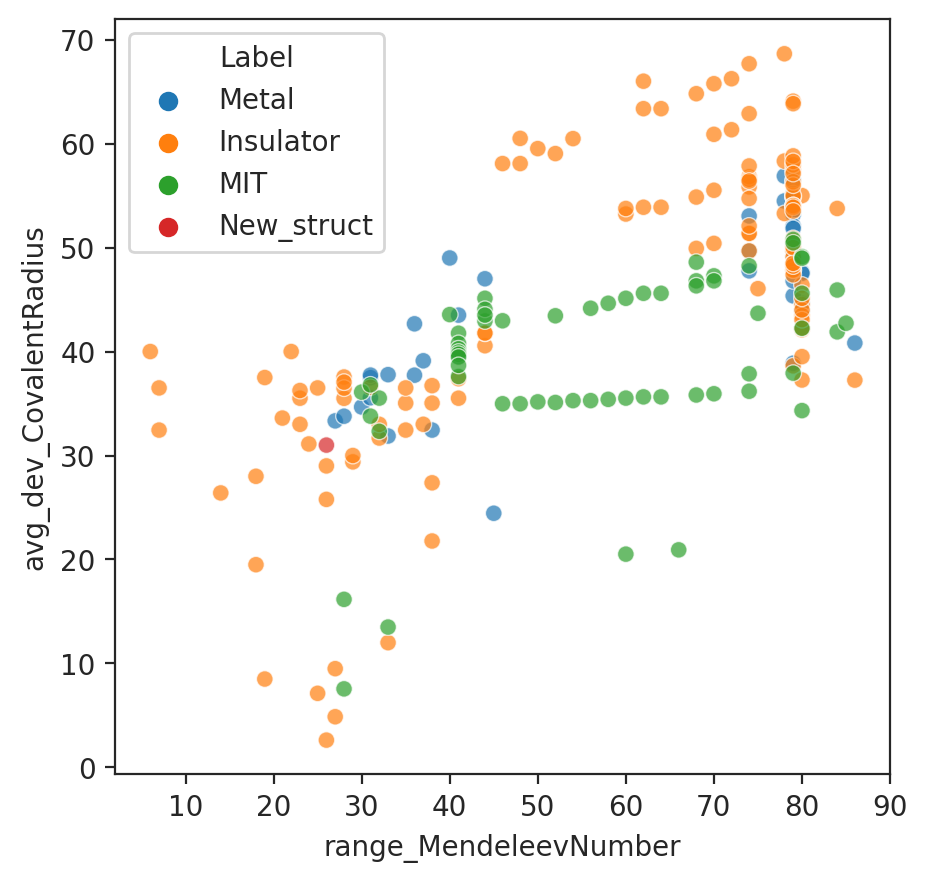

In [16]:
with sns.axes_style("ticks"):
    plt.figure(figsize=(5,5), dpi=200)
    sns.scatterplot(data=combined_df_plot, x=x_plot, y=y_plot, hue="Label", alpha=0.7)

### Here is an interactive version with Plotly

Things you can do

1. Hover your cursor over data points to display the compound name, feature values and class label.
2. Drag your cursor to zoom in on a specific region and double left click to zoom out.
3. Click once on one of the class labels on the legend to hide the points within that class.
4. Click twice on one of the class labels on the legend to show only the points within that class.

In [17]:
mendeleev_cov_radius_fig = px.scatter(combined_df_plot, x=x_plot, y=y_plot, hover_name="Compound", 
                                      height=1000, width=1000, color="Label", template="simple_white"
                                     )
mendeleev_cov_radius_fig.update_traces(mode='markers', marker_line_width=1, marker_size=10, marker_line_color="white")
mendeleev_cov_radius_fig.write_html("../plots/new_struct_mendeleev_cov_radius.html")
IFrame(src='../plots/new_struct_mendeleev_cov_radius.html', width=1100, height=1100)